# Exploring Restaurants in Berlin
#### by André Schlinke
### Abstract

This notebook explores the distribution of different types of restaurants in the center of Berlin. It specifically tries to answer the question where restaurants are located which offer german cuisine. Therefore the concentration of german restaurants are examined for the different boroughs of Berlin. Also, as a last objective, the clustering algorithm k-means is being used to detect culinary hot-spots for opening potential new german restaurants.

## Table of Content

[1. Introduction](#introduction)

> [1.1 Background](#background)
>
> [1.2 Problem](#problem)
>
> [1.3 Interest](#interest)

[2. Data](#data)

> [2.1 Data Sources](#data_sources)
>
> [2.2 Data Cleaning](#data_cleaning)

[3. Exploratory Data Analysis](#exploratory_data_analysis)

[4. Clustering](#clustering)

[5. Conclusion](#conclusion)

[6. Outlook](#outlook)

<a id='introduction'></a>
## 1. Introduction

<a id='background'></a>
### 1.1 Background

As a enthusiast of good, tasty food, I like to go out with my friends to new restaurants and try new dishes. Luckily this is pretty easy as a local of Berlin, the german capital. The city has a rich culinary scene to offer. Here one can find culinary styles from all over the world. And eating delicous, and exotic meals aren't soley for the ones with a bigger pocket money. The competion is fierce for the hungry tooth walking by.

I live in Wedding, a neighborhood which is part of the borough called Mitte (center). As a neighborhood for the working class, a lot of turkish and arabic families live here. It therefore makes sense that mostly doner and falafel restaurants are placed here. In general, Berlin has also a strong vietnamese community. Immigrants fleeing from the war back then. That is why you can find very good vietnamese restaurants all over berlin. It is also the vietnamese restaurant called Monsieur Vuong which is my favourite restaurant of all time. I even bought their cookbook. Whenever I a have someone visting me from out of town I use the opportunity to go to Monsieur Vuong and order some delicous meals.

<a id='problem'></a>
### 1.2 Problem

Berlin has lots of tourists visiting the city every year. Last year alone Berlin had over 10 million guests. It happens very quickly to bump into one of these tourists and have a little chat about the city. In these occasions I like to recommend my favourite spots of Berlin. However, whenever I get asked if I know a place where one could eat traditional german food, I shake my head and shrug my shoulders. To be honest, I have no idea. I barely see any german restaurants and I start to ask myself - Where are all those german restaurants in the german capital?

To highlight the problem even further - I love to watch the documentary series at Netflix called 'Chef's Table' portraying different chefs from all over the world. In one episode the chef Tim Raue is being portrayed and even he, a local of Berlin, is famous for making extraordinary asion fusion cuisine.

Therefore, the question I want to investigate in this notebook is if there really is a lack of german restaurants in Berlin? And if not, where are all those restaurants located?


<a id='interest'></a>
### 1.3 Interest

This topic is not only of interest for me or my friends but also for the several million guests visiting the city every year. As tourist from outside of germany probably want to try german cuisine, this study could be a good advisor of where one would probably find a possible restaurant for lunch or dinner. Also future restaurateurs will get three suggestions at the end where to open a potential new restaurant.

<a id='data'></a>
## 2. Data

To tackle the above depicted problem we need a list of restaurants, their type of cuisine as well as their latitude and longitude. These informations can be gathered by the __Foursquare API__. However, to explore the different venues of a specific area, a radius as well as latitude and longitude values need to be provided by the user. Therefore we take the latitude and longitude of the different postal codes which we get by the __pgeocode__ library. A hand-picked selection of postal codes, their corresponding neighborhoods, as well as their boroughs a provided by a __CSV-file__ which contains data gained by [this](https://de.wikipedia.org/wiki/Liste_der_Bezirke_und_Ortsteile_Berlins) wikipedia article.

<a id='data_sources'></a>
### 2.1 Data Sources

In this study a hand-picked selection of the core neighborhoods of Berlin are being analyzed. The data of the different neighborhoods and boroughs were taken from a wikipedia article which you can find [here](https://de.wikipedia.org/wiki/Liste_der_Bezirke_und_Ortsteile_Berlins). The data are provided by a CSV-file which contain the different postal codes, neighborhoods and boroughs.

Let's start by importing the several libraries necessary for this notebook.

In [74]:
import numpy as np
import pandas as pd
import pgeocode # library to get latitude and longitude of postal code

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns
sns.set()

# import k-means from clustering stage
from sklearn.cluster import KMeans

# import standard scaler for jointplot
from sklearn.preprocessing import StandardScaler

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#!pip install folium
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


To get a idea of the content of the CSV-file, we read in the file as the DataFrame object __df__ and print the first 5 lines of the DataFrame.

In [75]:
df    = pd.read_csv('berlin_postcode.csv') # Read in CSV-file.
df.head() # Print first 5 lines of DataFrame df.

,Postcode,Neighborhood,Borough
0,10115,Mitte,Mitte
1,10117,Mitte,Mitte
2,10119,Mitte,Mitte
3,10178,Mitte,Mitte
4,10179,Mitte,Mitte


The DataFrame consits of three columns and 97 rows. One row per postal code.

In [76]:
df.shape # Print shape of DataFrame

(97, 3)

In [77]:
df.dtypes # Print DataTypes per column.

Postcode         int64
Neighborhood    object
Borough         object
dtype: object

We use the __pgeocode__ library to get the latitude and longitude of each postal code and save them in the new DataFrame __geo_df__.

In [78]:
nomi   = pgeocode.Nominatim('de') # Create Nominatim object for german (de) postal codes.
geo_df = nomi.query_postal_code(df['Postcode'].astype(str).values) # Get latitude and longitude of all postal codes.

In [79]:
geo_df['postal_code'] = geo_df['postal_code'].astype(int)
geo_df.dtypes # Check DataTypes of new  DataFrame.

postal_code         int64
country code       object
place_name         object
state_name         object
state_code         object
county_name        object
county_code         int64
community_name     object
community_code      int64
latitude          float64
longitude         float64
accuracy          float64
dtype: object

In [80]:
geo_df.head() # Print first 5 lines of the DataFrame geo_df.

,postal_code,country code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
0,10115,DE,Berlin,Berlin,BE,NaN,0,"Berlin, Stadt",11000,52.5323,13.3846,6.0
1,10117,DE,Berlin,Berlin,BE,NaN,0,"Berlin, Stadt",11000,52.5170,13.3872,6.0
2,10119,DE,Berlin,Berlin,BE,NaN,0,"Berlin, Stadt",11000,52.5305,13.4053,6.0
3,10178,DE,Berlin,Berlin,BE,NaN,0,"Berlin, Stadt",11000,52.5213,13.4096,6.0
4,10179,DE,Berlin,Berlin,BE,NaN,0,"Berlin, Stadt",11000,52.5122,13.4164,6.0


Let's __merge__ the content of the postal codes provided in the DataFrame __df__ with the corresponding latitude and longitude of the DataFrame __geo_df__ into the new DataFrame __berlin_data__.

In [81]:
berlin_data = pd.merge(df, geo_df[['postal_code', 'latitude', 'longitude']], how='left', left_on=['Postcode'], right_on=['postal_code']) # Merge the two DataFrames.

berlin_data.drop(['postal_code'], axis=1, inplace=True) # Drop reduntant column
berlin_data.rename(columns={'latitude':'Latitude', 'longitude':'Longitude'}, inplace=True)
berlin_data.drop_duplicates(inplace=True) # Drop duplicate rows
berlin_data.head()

,Postcode,Neighborhood,Borough,Latitude,Longitude
0,10115,Mitte,Mitte,52.5323,13.3846
1,10117,Mitte,Mitte,52.5170,13.3872
2,10119,Mitte,Mitte,52.5305,13.4053
4,10178,Mitte,Mitte,52.5213,13.4096
6,10179,Mitte,Mitte,52.5122,13.4164


### Coordinates of Berlin, Germany

#### Latitude: 52.5200°, Longitutde: 13.4050°

Information of the latitude and longitude of Berlin were provided by a quick google search.

In [82]:
berlin_latitude, berlin_longitude = 52.5200, 13.4050 # Latitude and longitude of Berlin.

Define function to summarize all neighborhoods to one postal code.

In [83]:
def to_comma_sep_row(df): # Summarizes all neighborhoods with same postal code.
    if df['Neighborhood'].dropna().size == 0:
        df['Neighborhood'] = df['Borough']
    else:
        df['Neighborhood'] = ', '.join(df['Neighborhood'].unique().tolist())
    return df
    
berlin_data = berlin_data.groupby(['Postcode', 'Borough', 'Latitude', 'Longitude']).apply(to_comma_sep_row).drop_duplicates()

Now we create a dictionary containing different colors for each borough.

In [84]:
# colors uses a color map, which will produce an array of colors based on
# the number of labels. We use set(k_means_labels) to get the
# unique labels.
colors_arr   = cm.Paired(np.linspace(0, 1, len(set(berlin_data['Borough']))))

col_dict = {b:colors.to_hex(c) for b, c in zip(set(berlin_data['Borough']), colors_arr)}

### Let's create a map displaying the locations of the different postal codes, as well as the neighborhood they belong to. Each color represents a dfferent borough.

In [85]:
# create map of Berlin using latitude and longitude values
map_berlin = folium.Map(location=[berlin_latitude, berlin_longitude], zoom_start=12)

# add markers to map
for lat, lng, postcode, borough, name in zip(berlin_data['Latitude'], berlin_data['Longitude'], berlin_data['Postcode'], berlin_data['Borough'], berlin_data['Neighborhood']):
    label = folium.Popup(name, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=col_dict[borough],
        fill_opacity=0.7,
        parse_html=False).add_to(map_berlin)  
    
map_berlin

In [86]:
# @hidden_cell
CLIENT_ID = 'BQL4EG0F0DFM4INHCCZGJ0ONRSQQT4BOYFHGJFC4PLOOY34U' # your Foursquare ID
CLIENT_SECRET = 'KG43YLNKTUGPCCZERULKWGBEALVAA3R21TMQAWIZ2QYSZCS2' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Get latitude and longitude of first postal code in DataFrame __berlin_data__.

In [87]:
neighborhood_latitude  = berlin_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = berlin_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name      = berlin_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Mitte are 52.5323, 13.3846.


Let's __explore__ the different venues of the first postal code using the __Foursquare API__. Therefore we limit the no. of venues to 100 and explore an area within a radius of 500 meters.

In [88]:
LIMIT = 100 # Limit no. of venues to 100.
neighborhood_radius = 500 # Explore venues within the radius.

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, VERSION, neighborhood_radius, LIMIT)

In [89]:
results = requests.get(url).json() # Get results of request.

<a id='data_cleaning'></a>
### 2.2 Data Cleaning

The exploration of the venues within a given radius returns a number of different categories of venues. As we are only interested in restaurants for our problem, we only consider categories which contain the string 'Restaurant' in their category. It is clear, that we thereby neglect venues which belong to categories such as 'Fast Food' or 'Food & Drink'. However, as these types do not provide further details on the origin of the respective cuisine style, we consider this neglect as reasonable. Therefore we only focus on restaurants as they generally provide also the local origin of their cuisine in the category name. 

In [90]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [91]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_restaurants    = nearby_venues.drop(nearby_venues[~nearby_venues['categories'].str.contains('Restaurant')].index) # Drop all venues which do not contain the string 'Restaurant'
nearby_restaurants

,name,categories,lat,lng
9,Cô Chu Vietnamese Gourmet,Vietnamese Restaurant,52.531022,13.384755
14,+84,Vegetarian / Vegan Restaurant,52.532639,13.379511
20,Petrarca,Italian Restaurant,52.529143,13.388316
21,Nordbahnhof Two Buddhas,Asian Restaurant,52.532359,13.384974
22,Schnitzelei,Schnitzel Restaurant,52.528563,13.387228
23,EINS,German Restaurant,52.529460,13.388039
32,Takumi NINE Sapporo,Ramen Restaurant,52.529055,13.384863
44,+84 Asian Deli,Asian Restaurant,52.532419,13.379518


Let's create a first map containing also the restaurants of the first postal code.

In [92]:
# create map of Berlin using latitude and longitude values
map_berlin = folium.Map(location=[berlin_latitude, berlin_longitude], zoom_start=12)

# add neighborhood markers to map
for lat, lng, neighborhood, borough in zip(berlin_data['Latitude'], berlin_data['Longitude'], berlin_data['Neighborhood'], berlin_data['Borough']):
    label = folium.Popup(neighborhood, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=col_dict[borough],
        fill_opacity=0.7,
        parse_html=False).add_to(map_berlin)  

# add restaurants markers to map
for lat, lng, name in zip(nearby_restaurants['lat'], nearby_restaurants['lng'], nearby_restaurants['name']):
    label = folium.Popup(name, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label).add_to(map_berlin)  
    
map_berlin

Now let's get the restaurants nearby all postal code locations.

In [93]:
def getNearbyRestaurants(postcodes, latitudes, longitudes, boroughs, radius=500): # Gets restaurants per Foursquare API request.
    
    restaurants_list=[]
    for postcode, lat, lng, borough in zip(postcodes, latitudes, longitudes, boroughs):
        print(postcode)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        restaurants_list.append([(
            postcode, 
            lat, 
            lng,
            borough,
            r['venue']['name'], 
            r['venue']['location']['lat'], 
            r['venue']['location']['lng'],  
            r['venue']['categories'][0]['name']) for r in results])

    nearby_restaurants = pd.DataFrame([item for restaurants_list in restaurants_list for item in restaurants_list])
    nearby_restaurants.columns = ['Postcode', 
                  'Postcode Latitude', 
                  'Postcode Longitude',
                  'Borough',
                  'Restaurant', 
                  'Restaurant Latitude', 
                  'Restaurant Longitude', 
                  'Restaurant Category']
    
    return(nearby_restaurants.drop(nearby_restaurants[~nearby_restaurants['Restaurant Category'].str.contains('Restaurant')].index))

In [94]:
berlin_restaurants = getNearbyRestaurants(postcodes=berlin_data['Postcode'],
                                   latitudes=berlin_data['Latitude'],
                                   longitudes=berlin_data['Longitude'],
                                   boroughs=berlin_data['Borough']
                                  )

10115
10117
10119
10178
10179
10551
10553
10555
10557
10559
13353
10785
10787
13347
13349
13351
13357
13359
13407
13355
13409
10243
10245
10247
10249
10178
10179
10317
10961
10963
10965
10967
10997
10999
10969
10119
10247
10249
10369
10405
10407
10409
10435
10437
10439
13187
13189
10585
10587
10589
10623
10625
10627
10629
14052
14055
14057
14059
10707
10709
10713
10715
10717
10719
10777
14197
10777
10779
10781
10783
10787
10789
10823
10825
10827
10829
12157
12159
12161
12169
12043
12045
12047
12049
12051
12053
12055
12057
12059


In [95]:
berlin_restaurants.head()

,Postcode,Postcode Latitude,Postcode Longitude,Borough,Restaurant,Restaurant Latitude,Restaurant Longitude,Restaurant Category
9,10115,52.5323,13.3846,Mitte,Cô Chu Vietnamese Gourmet,52.531022,13.384755,Vietnamese Restaurant
14,10115,52.5323,13.3846,Mitte,+84,52.532639,13.379511,Vegetarian / Vegan Restaurant
20,10115,52.5323,13.3846,Mitte,Petrarca,52.529143,13.388316,Italian Restaurant
21,10115,52.5323,13.3846,Mitte,Nordbahnhof Two Buddhas,52.532359,13.384974,Asian Restaurant
22,10115,52.5323,13.3846,Mitte,Schnitzelei,52.528563,13.387228,Schnitzel Restaurant


In [96]:
berlin_restaurants.shape

(1106, 8)

In [97]:
berlin_restaurants = berlin_restaurants[['Borough', 'Restaurant', 'Restaurant Latitude', 'Restaurant Longitude', 'Restaurant Category']]

In order to not consider restaurants multiple times, we drop duplicate listings of restaurants.

In [98]:
berlin_restaurants.reset_index(drop=True, inplace=True)

berlin_restaurants.drop_duplicates(inplace=True) # Drop duplicate restaurants
berlin_restaurants.shape

(1009, 5)

<a id='exploratory_data_analysis'></a>
## 3. Exploratory Data Analysis

Now let's explore the data we gained so far. In a first step we plot the location of the all the restaurants found.

In [99]:
# create map of Berlin using latitude and longitude values
map_berlin = folium.Map(location=[berlin_latitude, berlin_longitude], zoom_start=12)

# add neighborhood markers to map
for lat, lng, neighborhood, borough in zip(berlin_data['Latitude'], berlin_data['Longitude'], berlin_data['Neighborhood'], berlin_data['Borough']):
    label = folium.Popup(neighborhood, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=col_dict[borough],
        fill_opacity=0.7,
        parse_html=False).add_to(map_berlin)  

# add restaurants markers to map
for lat, lng, name in zip(berlin_restaurants['Restaurant Latitude'], berlin_restaurants['Restaurant Longitude'], berlin_restaurants['Restaurant']):
    label = folium.Popup(name, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label).add_to(map_berlin)  
    
map_berlin

The map turns out to be a little confusing due to the huge number of restaurants. Even though we can more or less guess where concentrations of restaurants are, we like to create a jointplot to get a better understanding of the distribution of the restaurants in Berlin. We therefore standardize the latitude and longitude values.

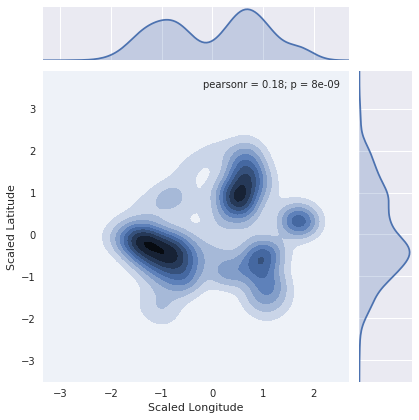

In [100]:
loc_data        = berlin_restaurants[['Restaurant Latitude', 'Restaurant Longitude']]
scaler          = StandardScaler()
scaled_loc_data = pd.DataFrame(scaler.fit_transform(loc_data), columns=['Scaled Latitude', 'Scaled Longitude'])

sns.jointplot(x='Scaled Longitude', y='Scaled Latitude', data=scaled_loc_data, kind='kde')

As the figure above depicts, there are more restaurants in the east of berlin than in the west. Also restaurants are more concentrated in the south than in the north of the city. So it seems that Wedding, the area where I live, has turned out to be the least favorable neighborhood for me, who loves to go to restaurants.

Now we count the different types of restaurants in Berlin.

In [101]:
cuisine_df = berlin_restaurants.groupby('Restaurant Category')['Restaurant Category'].count().reset_index(name='No. Restaurants in Berlin').sort_values(by='No. Restaurants in Berlin', ascending=False)
cuisine_df.reset_index(drop=True, inplace=True)
cuisine_df['Restaurant Category'] = cuisine_df['Restaurant Category'].str.replace('Restaurant', '')
cuisine_df['Restaurant Category'] = cuisine_df['Restaurant Category'].str.strip()
cuisine_df.loc[cuisine_df[cuisine_df['Restaurant Category'] == ''].index, 'Restaurant Category'] = 'General'
cuisine_df.shape

(72, 2)

There are 72 different types of restaurants in Berlin. These types could be further diminished since there are broad categories such as 'Asian' or 'General' which could be further broken down into the different categories. However, as we are mostly interested in german and non-german restaurants, we leaf the categories as they are.

To see if Berlin does really lack of german restaurants we print the __top 20__ categories of restaurants in Berlin.

In [102]:
cuisine_df.head(20)

,Restaurant Category,No. Restaurants in Berlin
0,Italian,140
1,Vietnamese,103
2,German,88
3,General,46
4,Doner,41
5,Asian,41
6,Vegetarian / Vegan,40
7,Falafel,38
8,Indian,35
9,Korean,33


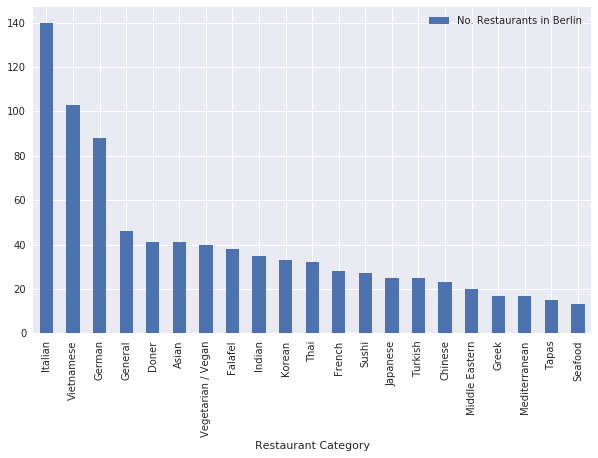

In [103]:
cuisine_df.loc[:20].plot(kind='bar', x='Restaurant Category', figsize=(10,6))

As it turns out, __german restaurants__ are on the __third place__ of number of restaurants in Berlin with a total of 88 restaurants. To be honest, I did not expect this. There are __only more vietnamese and italian restaraunts__ with italian being the most type of restaurants in berlin with a total number of 140 restaurants found. This confirms more or less the impression I got from the restaurants in Berlin. It is a common fact that Germany is a pasta loving country.

In [104]:
no_german_restaurants = cuisine_df[(cuisine_df['Restaurant Category'] == 'German')].iloc[0,1]
print("The share of german restaurants in Berlin is {0:0.1f}%.".format(100*no_german_restaurants/cuisine_df['No. Restaurants in Berlin'].sum()))

The share of german restaurants in Berlin is 8.7%.


We create the new DataFrame __german_restaurants__ containing only the restaurants with german cuisine.

In [105]:
german_restaurants   = berlin_restaurants.drop(berlin_restaurants[~berlin_restaurants['Restaurant Category'].str.contains('German')].index)

We then plot this time only the location of the german restaurants to see where they are mostly located at.

In [106]:
# create map of Berlin using latitude and longitude values
map_berlin = folium.Map(location=[berlin_latitude, berlin_longitude], zoom_start=12)

# add neighborhood markers to map
for lat, lng, neighborhood, borough in zip(berlin_data['Latitude'], berlin_data['Longitude'], berlin_data['Neighborhood'], berlin_data['Borough']):
    label = folium.Popup(neighborhood, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=col_dict[borough],
        fill_opacity=0.7,
        parse_html=False).add_to(map_berlin)  

# add restaurants markers to map
for lat, lng, name in zip(german_restaurants['Restaurant Latitude'], german_restaurants['Restaurant Longitude'], german_restaurants['Restaurant']):
    label = folium.Popup(name, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label).add_to(map_berlin)  
    
map_berlin

In [107]:
german_restaurants.head()

,Borough,Restaurant,Restaurant Latitude,Restaurant Longitude,Restaurant Category
5,Mitte,EINS,52.529460,13.388039,German Restaurant
13,Mitte,Gendarmerie,52.515719,13.390940,German Restaurant
14,Mitte,Nante-Eck,52.516959,13.388249,German Restaurant
18,Mitte,Augustiner am Gendarmenmarkt,52.513990,13.391001,German Restaurant
19,Mitte,Ständige Vertretung,52.520945,13.385994,German Restaurant


It seems like there are a lot of german restaurants in the borough Charlottenburg-Wilmersdorf. To confim this, we create another jointplot figure.

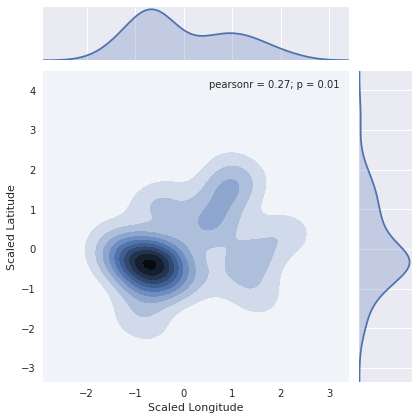

In [108]:
loc_data        = german_restaurants[['Restaurant Latitude', 'Restaurant Longitude']]
scaler          = StandardScaler()
scaled_loc_data = pd.DataFrame(scaler.fit_transform(loc_data), columns=['Scaled Latitude', 'Scaled Longitude'])

sns.jointplot(x='Scaled Longitude', y='Scaled Latitude', data=scaled_loc_data, kind='kde')

The jointplot clearly indicates a concentration of german restaurants in the south west of Berlin. We analyze this further by listing the number of german restaurants per borough.

In [109]:
gr_pb_df  = german_restaurants.groupby('Borough')['Restaurant'].count().reset_index(name='Number of German Restaurants').sort_values(by='Number of German Restaurants', ascending=False).reset_index(drop=True)

In [110]:
gr_pb_df

,Borough,Number of German Restaurants
0,Charlottenburg-Wilmersdorf,26
1,Tempelhof-Schöneberg,18
2,Mitte,17
3,Friedrichshain-Kreuzberg,12
4,Pankow,11
5,Neukölln,4


As expected, Charlottenburg-Wilmersdorf is the borough with the most german restaurants. Interestingly, Neukölln, a borough similar to wedding, is a borough for the working class with also lots of arabic and turkish families. This borough is very famous for it's rich nightlife as well as for its exotic culinary scene, whereas Charlottenburg-Wilmersdorf is more inhabited by the middle and upper class. It is interesting that this fact shows off so clearly by the type of cuisine located in each borough. To back this up we investigate the percentage of german restaurant for the different boroughs.

In [111]:
br_pb_df  = berlin_restaurants.groupby('Borough')['Restaurant'].count().reset_index(name='Number of Restaurants').sort_values(by='Number of Restaurants', ascending=False).reset_index(drop=True)

In [112]:
br_pb_df

,Borough,Number of Restaurants
0,Charlottenburg-Wilmersdorf,225
1,Friedrichshain-Kreuzberg,189
2,Pankow,188
3,Mitte,170
4,Tempelhof-Schöneberg,149
5,Neukölln,88


In [113]:
pb_df = pd.merge(br_pb_df, gr_pb_df, on='Borough')

In [114]:
pb_df['Percentage of German Restaurants'] = pb_df['Number of German Restaurants'].astype(float)/pb_df['Number of Restaurants'].astype(float)

In [115]:
pb_df.sort_values(by='Percentage of German Restaurants')

,Borough,Number of Restaurants,Number of German Restaurants,Percentage of German Restaurants
5,Neukölln,88,4,0.045455
2,Pankow,188,11,0.058511
1,Friedrichshain-Kreuzberg,189,12,0.063492
3,Mitte,170,17,0.100000
0,Charlottenburg-Wilmersdorf,225,26,0.115556
4,Tempelhof-Schöneberg,149,18,0.120805


Neukölln has the lowest rate of german restaurants with only 5% whereas Tempelhof-Schöneberg has the highest concentration with almost 13% followed by Charlottenburg-Wilmersdorf with 11%.

<a id='clustering'></a>
## 4. Clustering

In this chapter we use the clustering algorithm k-means to determine 3 hot-spots of non-german restaurants, so that motivated newcomer restaurateurs of the german cuisine can have a recommendation of where to open their new restaurant. We, therefore, only need the latitude and longitude values of the non-german restaurants to train the algorithm. The outcoming three cluster centers are then considered to be our recommendations.

In [116]:
# set number of clusters
kclusters = 3

non_german_restaurants_clustering   = berlin_restaurants.drop(berlin_restaurants[~berlin_restaurants['Restaurant Category'].str.contains('German')].index)
non_german_restaurants_clustering   = non_german_restaurants_clustering[['Restaurant Latitude', 'Restaurant Longitude']]

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(non_german_restaurants_clustering)

# check cluster centers generated from dataframe
kmeans.cluster_centers_

array([[52.50001955, 13.44249695],
       [52.53063379, 13.40076852],
       [52.5001457 , 13.33383166]])

In [117]:
cluster_df = pd.DataFrame(kmeans.cluster_centers_, columns=['Latitude', 'Longitude'])
cluster_df.reset_index(inplace=True)
cluster_df.columns = ['Cluster', 'Latitude', 'Longitude']
cluster_df

,Cluster,Latitude,Longitude
0,0,52.500020,13.442497
1,1,52.530634,13.400769
2,2,52.500146,13.333832


Now that we have our three coordinates, let's plot them.

In [119]:
# create map of Berlin using latitude and longitude values
map_berlin = folium.Map(location=[berlin_latitude, berlin_longitude], zoom_start=12)

# add neighborhood markers to map
for lat, lng, neighborhood, borough in zip(berlin_data['Latitude'], berlin_data['Longitude'], berlin_data['Neighborhood'], berlin_data['Borough']):
    label = folium.Popup(neighborhood, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=col_dict[borough],
        fill_opacity=0.7,
        parse_html=False).add_to(map_berlin)  
    
# add restaurants markers to map
for lat, lng, name in zip(cluster_df['Latitude'], cluster_df['Longitude'], cluster_df['Cluster']):
    label = folium.Popup(name, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup='Possible Spot #'+str(name+1),
        icon=folium.Icon(color='red')).add_to(map_berlin)  
    
map_berlin

Wow. I am pretty impressed by the location of the cluster centers, as two of them are my favourite spots to go out to eat delicous food. 

* The first recommendation is located at the metro station __U Schlesisches Tor__. It's in Kreuzberg and one of the go to areas if you want to party. There are a lot of nightclubs playing techno music and also some very good spots to get something to eat. My recommendation there would be the __Burgermeister__ which is located in an old public toilet. It sounds disgusting but it is delicous. Check it out.

* The second cluster center and therefore our recommendation would be the __Rosenthaler Platz__ in Prenzlauer Berg. This makes total sense since I would consider this the number one spot of delicous food in Berlin. Here a number of very good asian food restaurants. This is definetly a culinary hot-spot and it is funny that the clustering algorithm is so precisely in detecting it. Just to give you a view recommendations: __Transit__, __District Mot__, or __Shiso Burger__ are definetly places one should check out there. But what is missing there is definitely a german restaurant. So this would be a very good spot.

* The last recommendation would be in the __Lietzenburger Straße__ at the border of Schöneberg and Wilmersdorf. To be honest, I barely go out to eat in this area of the city so I have no recommendation of places to eat nearby. However, I should definitely check it out. As we discussed earlier, the __competion__ in this area for german restaurants is higher, nevertheless german restaurants seem to be pretty successful there. So this spot makes also total sense.

<a id='conclusion'></a>
## 5. Conclusion

We have successfully analyzed the amount of german restaurants in the center of Berlin, as well as there exact locations. We have detected a concentration of german restaurants in the boroughs Charlottenburg-Wilmersdorf and Tempelhof-Schöneberg. We also have determined the favourite types of restaurants in Berlin with italian being the most common type followed by vietnamese and german restaurants. The finding of german restaurants being at the third place of amount of restaurants in Berlin does not support our assumptions at the beginning that there would be a lack of german restaurants in Berlin. As it turns out, this type of cuisine is centered specially in the south west of Berlin. The borough with the least amount and concentration of german restaurants is Neukölln.

As a last point we have used the location of the non-german restaurants to create three recommendation of culinary hot-spot which would probably very interesting for opening a new german restaurant or a new restaurant in general using the k-means clustering algorithm.

<a id='outlook'></a>
## 6. Outlook

In this study the focus was on german restaurants. But the insights gained in this research could be extended by other type of restaurants. For example, which borough has the most italian or vietnamese restaurants. Also which borough has the most uncommon types of restaurants? These are questions which could be further investigated.

## Thank You!